Welcome to the demonstration Jupyter notebook for ISS LIS background geolocation. This part of ISS_Camera_Geolocate will geolocate background images from ISS LIS using the legacy LIS code. This has been converted from C to Python, with some help from Cython to speed up a few calculations.

Notebook Author:<br>
Timothy Lang<br>
timothy.j.lang@nasa.gov

Information about ISS LIS (Blakeslee et al. 2020): https://doi.org/10.1029/2020JD032918

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import cartopy.crs as ccrs
import xarray
import os
import glob
import iss_camera_geolocate as icg
%matplotlib inline

Get ISS LIS background imagery files from:<br>
http://dx.doi.org/10.5067/LIS/ISSLIS/DATA206 - near-realtime<br>
http://dx.doi.org/10.5067/LIS/ISSLIS/DATA207 - post-processed, non-quality-controlled<br>

Note that these background imagery data files are separate from the ISS LIS lightning data products. If you want a complete set of both lightning and background files, you will need to download both types of products. See Blakeslee et al. (2020) for more information.

In [2]:
bfiles = sorted(glob.glob('/Volumes/Lightning/LIS/Backgrounds/20??/??/*.nc'))
bfiles

['/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170611_NQC_02516.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02517.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02518.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02519.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02520.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02521.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02522.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02523.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02524.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02525.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_20170612_NQC_02526.nc',
 '/Volumes/Lightning/LIS/Backgrounds/2017/06/ISS_LIS_BG_V1.0_2017

In [3]:
# Use xarray to open a file
lisb = xarray.open_dataset(bfiles[-5])
lisb

<xarray.Dataset>
Dimensions:                                 (bg_info_dim: 5556, corners_dim: 8, event_count_dim: 6, latlon_dim: 2, tdim: 155, transform_matrix_dim: 9, vector_dim: 3, xdim: 128, ydim: 128)
Coordinates:
    bg_data_summary_TAI93_time              (tdim) datetime64[ns] ...
    bg_data_summary_lat                     (tdim) float32 ...
    bg_data_summary_lon                     (tdim) float32 ...
    bg_info_TAI93_time                      (bg_info_dim) datetime64[ns] ...
Dimensions without coordinates: bg_info_dim, corners_dim, event_count_dim, latlon_dim, tdim, transform_matrix_dim, vector_dim, xdim, ydim
Data variables:
    bg_data                                 (tdim, ydim, xdim) float32 ...
    bg_orbit_summary_id_number              int32 ...
    bg_orbit_summary_TAI93_start            datetime64[ns] ...
    bg_orbit_summary_UTC_start              object ...
    bg_orbit_summary_GPS_start              timedelta64[ns] ...
    bg_orbit_summary_TAI93_end              

In this file (which covers one orbit) there are 155 separate background images (tdim). They are typically spaced 30-60 seconds apart (ISS LIS images at 500 frames per second, but only a fraction of these frames are sent down from the ISS). Use the following function to peruse the images and find some worth geolocating.

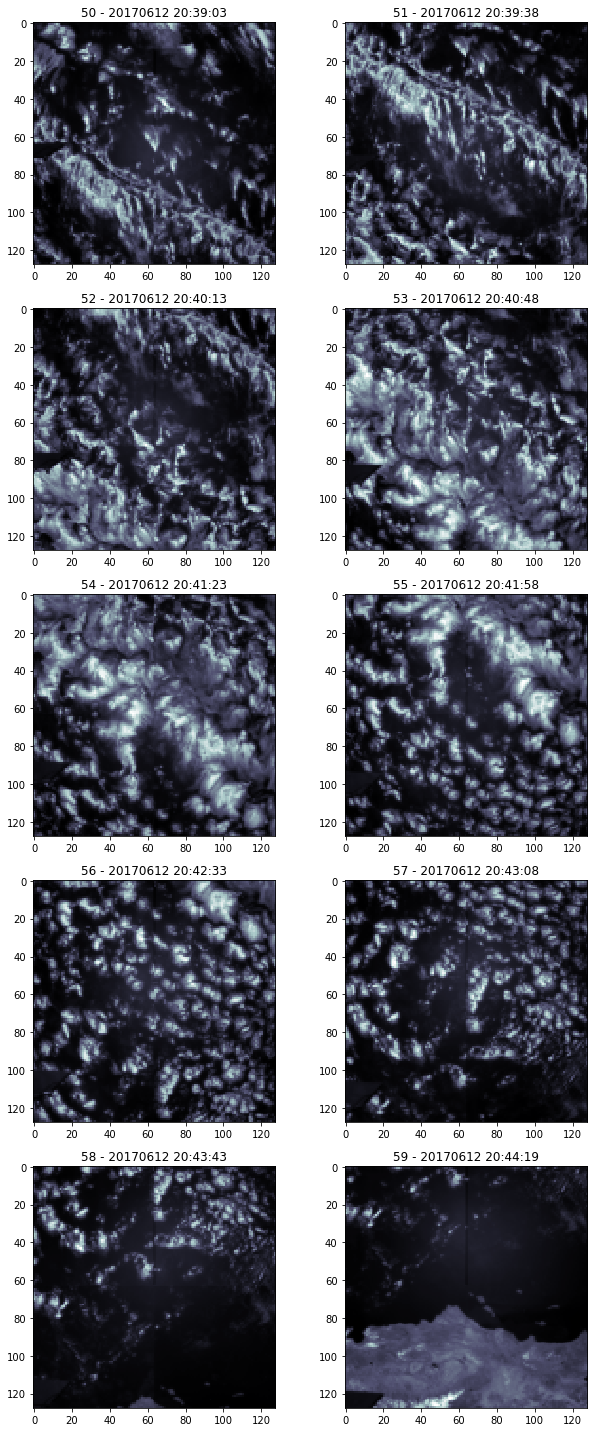

In [4]:
# This function plots 10 background images at a time.
icg.plot_series_of_backgrounds(lisb, 50)

Looks like the last image has some interesting coastline, let's look more closely. First, there is already some limited geolocation information in the background files, like boresight and corner lat/lon information. Let's use that to investigate potential surrounding images.

In [5]:
def get_corner_lon_lat(bg_corners, index):
    corners = 1.0 * bg_corners[index, :]
    cornlon = 1.0 * corners[1::2]
    tmp = 1.0 * cornlon[2]
    cornlon[2] = 1.0 * cornlon[3]
    cornlon[3] = 1.0 * tmp
    cornlon = np.concatenate([cornlon, [cornlon[0]]])
    cornlat = 1.0 * corners[::2]
    tmp = 1.0 * cornlat[2]
    cornlat[2] = 1.0 * cornlat[3]
    cornlat[3] = 1.0 * tmp
    cornlat = np.concatenate([cornlat, [cornlat[0]]])
    return cornlon, cornlat

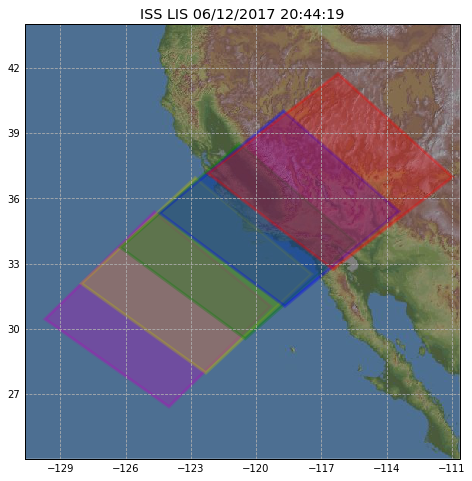

In [9]:
ii = 59
delt = 10
url = 'https://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
layer = 'ASTER_GDEM_Color_Shaded_Relief'

fig = plt.figure(figsize=(12, 8))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)

bdts = pd.to_datetime(
        lisb.bg_data_summary_TAI93_time.data).to_pydatetime()
ext = [lisb.bg_data_summary_boresight.data[ii, 1]-delt,
       lisb.bg_data_summary_boresight.data[ii, 1]+delt,
       lisb.bg_data_summary_boresight.data[ii, 0]-delt,
       lisb.bg_data_summary_boresight.data[ii, 0]+delt]
ax.set_extent(ext)
ax.add_wmts(url, layer)

cornlon, cornlat = get_corner_lon_lat(lisb.bg_data_summary_corners.data, ii-2)
ax.fill(cornlon, cornlat, color='m', alpha=0.3, transform=projection, lw=3)
cornlon, cornlat = get_corner_lon_lat(lisb.bg_data_summary_corners.data, ii-1)
ax.fill(cornlon, cornlat, color='y', alpha=0.3, transform=projection, lw=3)
cornlon, cornlat = get_corner_lon_lat(lisb.bg_data_summary_corners.data, ii)
ax.fill(cornlon, cornlat, color='g', alpha=0.3, transform=projection, lw=3)
cornlon, cornlat = get_corner_lon_lat(lisb.bg_data_summary_corners.data, ii+1)
ax.fill(cornlon, cornlat, color='b', alpha=0.3, transform=projection, lw=3)
cornlon, cornlat = get_corner_lon_lat(lisb.bg_data_summary_corners.data, ii+2)
ax.fill(cornlon, cornlat, color='r', alpha=0.3, transform=projection, lw=3)

ax.set_title('ISS LIS ' + bdts[ii].strftime('%m/%d/%Y %H:%M:%S'), fontsize='x-large')
gl = ax.gridlines(linestyle='--', draw_labels=True)
gl.ylabels_right = []
gl.xlabels_top = []

OK, we are looking at an overpass coming over California. The next background image (index 60) might be better for getting more of the land + ocean. Now let's run geolocation on this background image. The code is based on the ISS LIS lightning geolocation algorithm, and usually takes a few seconds to run on a decent computer. Lightning geolocated using this algorithm has sub-pixel location accuracy (< 4 km; Blakeslee et al. 2020), so expect similar accuracy with the background image geolocation.

In [10]:
ii = 60
locations = icg.run_iss_lis_geolocation(lisb, ii)

7.621336936950684 seconds to run


ISS LIS has a 128x128-pixel focal plane that provides ~4-km resolution near nadir. The output, "locations", is a 128 * 128 = 16384 x 2 array (lat, lon). You may need to reshape this back to 2D depending on your application. The numpy.reshape() function works really well for this. If you do reshape the arrays, remember to make sure that you transpose the ISS LIS background image (i.e., lisb.bg_data.data[index, :, :].T) to match up accordingly. The following quicklook function does this automatically.

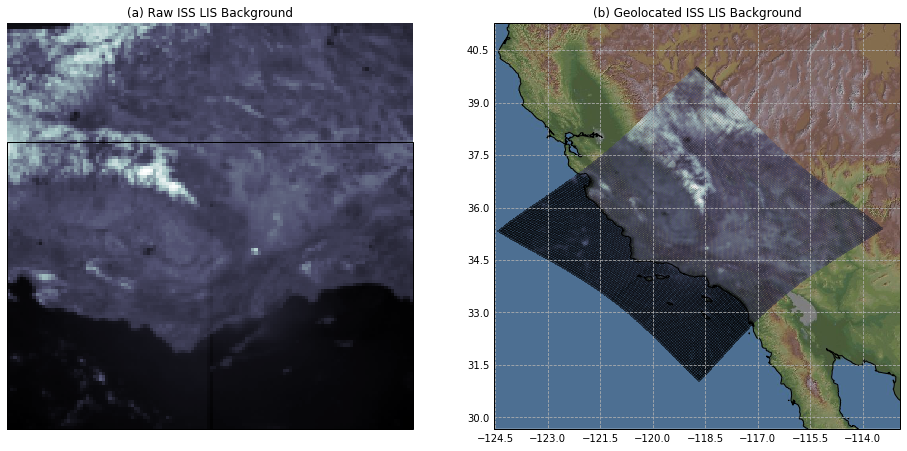

In [11]:
icg.plot_geolocated_quicklook(lisb, locations, ii)

Note: ISS LIS background imagery is not yet calibrated, and also may contain ISS solar panels/radiators within the field of view. Obviously, those objects are in space with the ISS. The imagery itself is from 777.4-nm wavelength (near-IR), which is more useful during the daytime (roughly half of each orbit) for mapping clouds and surface features.